In [2]:
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt

# Get list of all CSV files in the directory
list_of_files = list(Path("../../logs/performance_filters_fainder").rglob("*.csv"))

# Load in all files in df
df_latest = pd.DataFrame()
for file in list_of_files:
    df_latest = pd.concat([df_latest, pd.read_csv(file)])


# "timestamp","percentile", "comparison","reference","fainder_mode","execution_time","filter_size_right","filter_size_wrong","filter_size","num_results","num_results_without_filter","query","num_workers",
print(df_latest)

              timestamp  percentile comparison reference    fainder_mode  \
0   2025-07-18 16:25:55         0.5         le       100  full_precision   
1   2025-07-18 16:26:01         0.5         le       100  full_precision   
2   2025-07-18 16:26:07         0.5         le       100  full_precision   
3   2025-07-18 16:26:13         0.5         le       100  full_precision   
4   2025-07-18 16:26:19         0.5         le       100  full_precision   
..                  ...         ...        ...       ...             ...   
18  2025-07-18 16:15:46         0.1         le         1  full_precision   
19  2025-07-18 16:15:51         0.1         le         1  full_precision   
20  2025-07-18 16:15:57         0.1         le         1  full_precision   
21  2025-07-18 16:16:03         0.1         le         1  full_precision   
22  2025-07-18 16:16:09         0.1         le         1  full_precision   

    execution_time filter_size_right filter_size_wrong filter_size  \
0         0.02037

/tmp/ipykernel_16012/1052126668.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_latest = pd.concat([df_latest, pd.read_csv(file)])
/tmp/ipykernel_16012/1052126668.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_latest = pd.concat([df_latest, pd.read_csv(file)])
/tmp/ipykernel_16012/1052126668.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determ

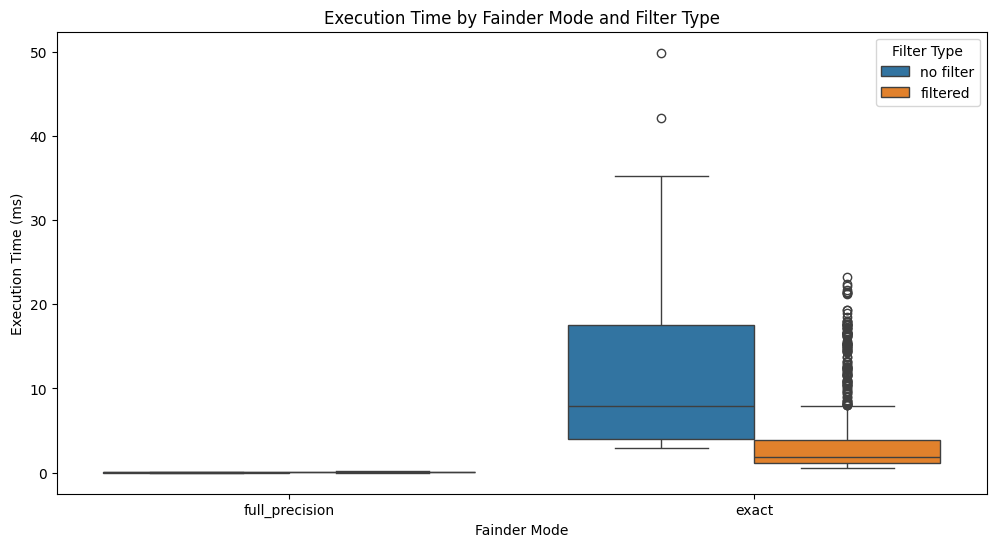

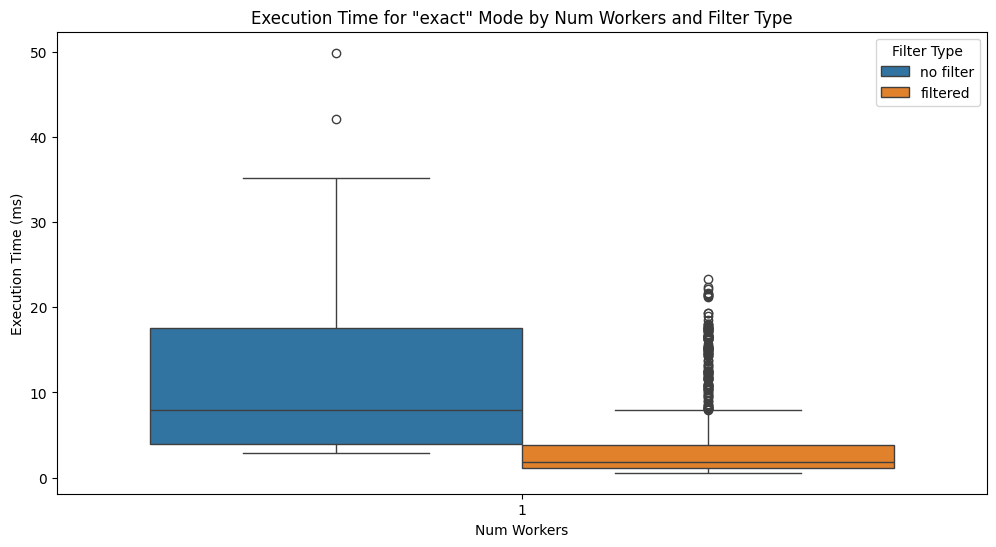

In [3]:
# Plot filter effectiveness (execution time) per fainder_mode and num_workers
import seaborn as sns

# Mark filter_size=0 as 'no filter'
df_latest["filter_type"] = df_latest["filter_size"].apply(
    lambda x: "no filter" if x == 0 else "filtered"
)

# Plot: Execution time by fainder_mode, filter_type, and num_workers (if mode is 'exact')
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_latest, x="fainder_mode", y="execution_time", hue="filter_type")
plt.title("Execution Time by Fainder Mode and Filter Type")
plt.ylabel("Execution Time (ms)")
plt.xlabel("Fainder Mode")
plt.legend(title="Filter Type")
plt.show()

# If fainder_mode == 'exact', plot by num_workers
if "exact" in df_latest["fainder_mode"].unique():
    df_exact = df_latest[df_latest["fainder_mode"] == "exact"]
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_exact, x="num_workers", y="execution_time", hue="filter_type")
    plt.title('Execution Time for "exact" Mode by Num Workers and Filter Type')
    plt.ylabel("Execution Time (ms)")
    plt.xlabel("Num Workers")
    plt.legend(title="Filter Type")
    plt.show()